In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2

In [ ]:
import re
import pandas as pd
import os
import tensorflow as tf

In [ ]:
train_dir = os.path.join('/content/gdrive/MyDrive/ЛЕТАЮЩИЕ НАСЕКОМЫЕ/train_butterflies')
valid_dir = os.path.join('/content/gdrive/MyDrive/ЛЕТАЮЩИЕ НАСЕКОМЫЕ/valid')

In [ ]:
img_shape=(224,224,3)


img_size = (img_shape[0], img_shape[1])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 4955 files belonging to 50 classes.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:

img_size = (img_shape[0], img_shape[1])
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    label_mode=None,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 250 files belonging to 1 classes.


In [ ]:
class_names = train_ds.class_names
class_count = len(class_names)

In [ ]:

class_names

['class_0',
 'class_1',
 'class_10',
 'class_11',
 'class_12',
 'class_13',
 'class_14',
 'class_15',
 'class_16',
 'class_17',
 'class_18',
 'class_19',
 'class_2',
 'class_20',
 'class_21',
 'class_22',
 'class_23',
 'class_24',
 'class_25',
 'class_26',
 'class_27',
 'class_28',
 'class_29',
 'class_3',
 'class_30',
 'class_31',
 'class_32',
 'class_33',
 'class_34',
 'class_35',
 'class_36',
 'class_37',
 'class_38',
 'class_39',
 'class_4',
 'class_40',
 'class_41',
 'class_42',
 'class_43',
 'class_44',
 'class_45',
 'class_46',
 'class_47',
 'class_48',
 'class_49',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

In [ ]:
%%time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

input = Input(shape = img_shape)

x = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", pooling='max')(input)
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dropout(rate=.2, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# model.compile(Adamax(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.compile(
    optimizer = Adamax(lr=.001),
    loss = tf.losses.SparseCategoricalCrossentropy(),
    # CategoricalCrossentropy()
    metrics = ['accuracy'])

history = model.fit(train_ds, validation_data = valid_ds, epochs = 6, verbose = 1)

43941136/43941136 [==============================] - 0s 0us/step


Epoch 1/6
331/331 [==============================] - 1005s 3s/step - loss: 1.6938 - accuracy: 0.6529 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
331/331 [==============================] - 83s 251ms/step - loss: 0.2407 - accuracy: 0.9320 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/6
331/331 [==============================] - 84s 251ms/step - loss: 0.1310 - accuracy: 0.9615 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/6
331/331 [==============================] - 83s 251ms/step - loss: 0.1156 - accuracy: 0.9689 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/6
331/331 [==============================] - 83s 250ms/step - loss: 0.0786 - accuracy: 0.9792 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/6
331/331 [==============================] - 84s 252ms/step - loss: 0.0579 - accuracy: 0.9820 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
CPU times: user 8min 25s, sys: 26.3 s, total: 8min 51s
Wall time: 27min 42s


In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

In [ ]:
epochs = range(1,len(acc)+1)

In [ ]:
import matplotlib.pyplot as plt


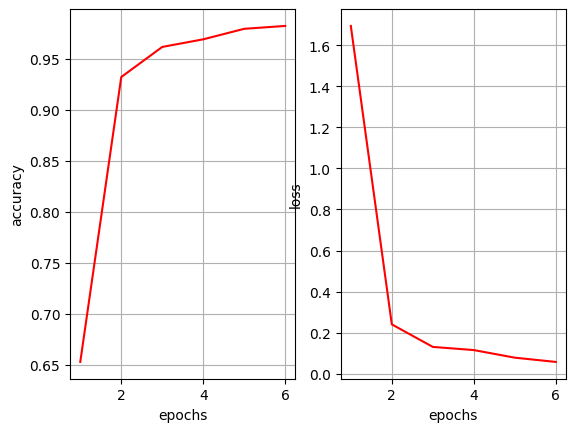

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, 'r', label="Training Accuracy")
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epochs')
ax1.grid()

ax2.plot(epochs, loss, 'r', label="Training Loss")
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.grid()

plt.show()

In [ ]:
test_path = '/content/gdrive/MyDrive/ЛЕТАЮЩИЕ НАСЕКОМЫЕ/valid'
import numpy as np

test = {
    'img': [],
    'index': []
}

for file in os.listdir(test_path):
    img = cv2.imread(f'{test_path}/{file}')
    test['img'].append(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    test['index'].append(int(file.replace('.jpg', '')))

test = {
    'img': np.array(test['img']),
    'index': np.array(test['index'])
}

preds = model.predict(test['img'], verbose=1)
preds

import numpy as np

ypred = []
for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = class_names[index]
    ypred.append(klass)

ypred = np.array(ypred)
df = pd.DataFrame(ypred, columns=['label'])
df['label'] = df['label'].str.replace("class_",'')
df['label'] = df['label'].astype(int)
df = df.reset_index()
df['index'] = test['index']

8/8 [==============================] - 8s 369ms/step


In [ ]:
type(history)

keras.src.callbacks.History

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [ ]:
from google.colab import files

df.to_csv('predictions2.csv', index=False)
files.download('predictions2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ans